In [1]:
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import auxFuncs as aux
import HbXConcentrations as hbx

In [2]:
# Load sample MC simulations

imagesMC1, shapeImagesMC1 = aux.loadMatStruct("MC2Inc660_2.mat", "flux")
imagesMC2, shapeImagesMC2 = aux.loadMatStruct("MC2Inc830_2.mat", "flux")

In [3]:
# Compute source centers

centersPos1 = np.empty((shapeImagesMC1[0],2))
centersPos2 = np.empty((shapeImagesMC2[0],2))

for i in range(shapeImagesMC1[0]):
    centersPos1[i] = aux.maxPosCm(imagesMC1[i], smooth=0)
    
for i in range(shapeImagesMC2[0]):
    centersPos2[i] = aux.maxPosCm(imagesMC2[i], smooth=0)

In [4]:
# Compute centered crops

imagesCentered1 = []
imagesCentered2 = []

cropSizeX = 70
cropSizeY = 70

for i, image in enumerate(imagesMC1):
    imageTemp = aux.cropAroundPosition(image, round(centersPos1[i][1]), round(centersPos1[i][0]), cropSizeX, cropSizeY) 
    imagesCentered1.append(imageTemp) 

for i, image in enumerate(imagesMC2):
    imageTemp = aux.cropAroundPosition(image, round(centersPos2[i][1]), round(centersPos2[i][0]), cropSizeX, cropSizeY) 
    imagesCentered2.append(imageTemp)  

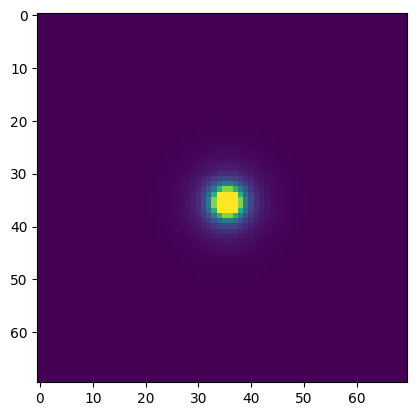

In [5]:
# Generate background normalization image

back1 = np.nanmean(imagesCentered1, axis=0)
back2 = np.nanmean(imagesCentered2, axis=0)
plt.imshow(back1)

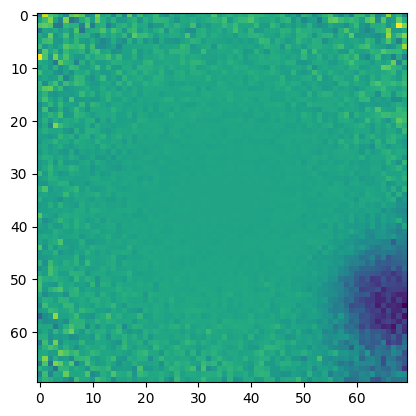

In [6]:
# Compute normalized crops

imagesDiv1 = imagesCentered1/back1
imagesDiv2 = imagesCentered2/back2
plt.imshow(imagesDiv1[12])

In [7]:
# Generate 2D reconstruction using gaussian weights

gaussianWeights = aux.gaussian2D(cropSizeX,cropSizeY,int(cropSizeX/2),int(cropSizeX/2),sigma=10,muu=0,contrast=0)

recon2DAll1, recon2DAllCount1 = aux.recon2D(imagesDiv1, centersPos1, weights=gaussianWeights)
recon2DAll2, recon2DAllCount2 = aux.recon2D(imagesDiv2, centersPos2, weights=gaussianWeights)


36it [00:00, 76.02it/s]
/home/nicolas/Bionirs/MamoRefCodePublic/auxFuncs.py:233: RuntimeWarning: invalid value encountered in divide
  imageRecon = imageReconTemp/imageReconCount
36it [00:00, 79.38it/s]


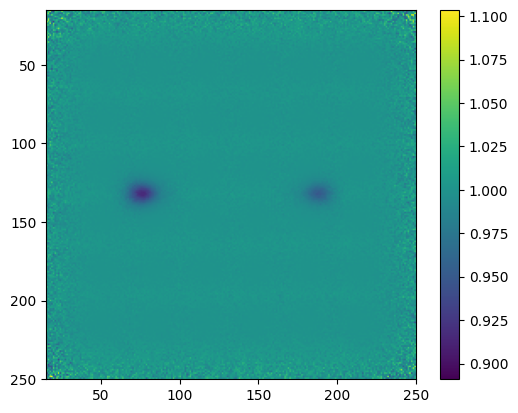

In [8]:
minValPos = 15

extent = [minValPos , 250, 250, minValPos]

recon2DCrop1 = recon2DAll1[minValPos:,minValPos:]
plt.imshow(recon2DCrop1, extent=extent)
plt.colorbar()

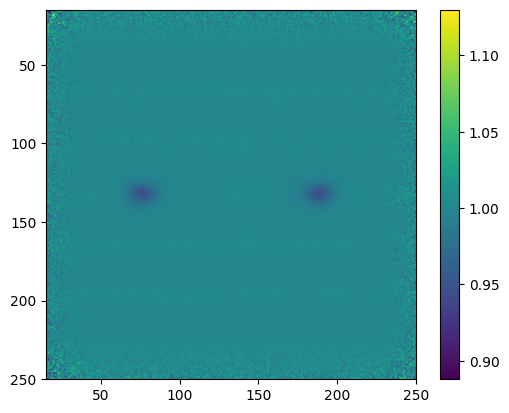

In [9]:
recon2DCrop2 = recon2DAll2[minValPos:,minValPos:]
plt.imshow(recon2DCrop2, extent=extent)
plt.colorbar()

In [10]:
imRaw = np.zeros((np.shape(recon2DCrop1)[0], np.shape(recon2DCrop1)[1], 2))
imRaw[:,:,0] = recon2DCrop1
imRaw[:,:,1] = recon2DCrop2

lambdas = [660, 830]

cropSize = 100

HbXMaps_2D = hbx.MamoRef_dHbX(imRaw, lambdas, centersPos1, cropSize, cropSize)
    
desOxyMap_2D = HbXMaps_2D[:,:,1]
OxyMap_2D = HbXMaps_2D[:,:,0]
TotMap_2D = desOxyMap_2D + OxyMap_2D

Step 1/2...


100%|██████████| 100/100 [00:06<00:00, 15.76it/s]


Step 2/2...


100%|██████████| 36/36 [00:11<00:00,  3.05it/s]
/home/nicolas/Bionirs/MamoRefCodePublic/HbXConcentrations.py:162: RuntimeWarning: invalid value encountered in divide
  LL = LL/cont


In [11]:
import scipy as sc

desOxyMap_2D_filtered = sc.ndimage.median_filter(desOxyMap_2D,4)
OxyMap_2D_filtered = sc.ndimage.median_filter(OxyMap_2D,4)

#desOxyMap_2D_filtered = desOxyMap_2D
#OxyMap_2D_filtered = OxyMap_2D

desOxyMap_2D_filtered[desOxyMap_2D_filtered==np.nan] = 0
OxyMap_2D_filtered[OxyMap_2D_filtered==np.nan] = 0

np.savetxt("MC2Incs_HbRMap.dat", desOxyMap_2D_filtered)
np.savetxt("MC2Incs_HbOMap.dat", OxyMap_2D_filtered)

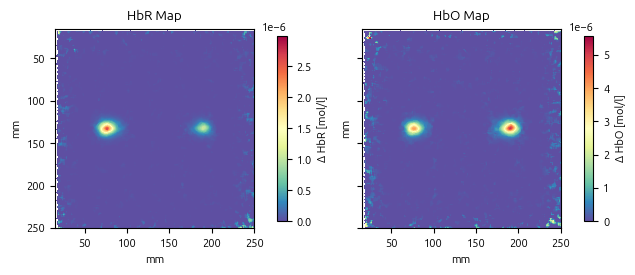

In [29]:
colorMap = "Spectral_r"
    
font = {'family' : 'ubuntu',
        'weight' : 'regular',
        'size'   : 8}

mp.rc('font', **font)

doTotMap = False

if doTotMap:
        figSats, ((DesOxy, Oxy, Tot)) = plt.subplots(1, 3, sharex=True, sharey=True)
        font["size"] = 6
        mp.rc('font', **font)
else:
        figSats, ((DesOxy,Oxy)) = plt.subplots(1, 2, sharex=True, sharey=True)

maxDev = 5   

sd = np.nanstd(desOxyMap_2D_filtered)
median = np.nanmedian(desOxyMap_2D_filtered)
vmax = median + maxDev * sd
vmin = 0

figDesOxy = DesOxy.imshow(desOxyMap_2D_filtered, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
c1 = figSats.colorbar(figDesOxy, ax=DesOxy, fraction=0.04, pad=0.1)
c1.set_label("Δ HbR [mol/l]")
DesOxy.set_xlabel("mm")
DesOxy.set_ylabel("mm")

sd = np.nanstd(OxyMap_2D_filtered)
median = np.nanmedian(OxyMap_2D_filtered)
vmax = median + maxDev * sd
vmin = 0


figOxy = Oxy.imshow(OxyMap_2D_filtered, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
c2 = figSats.colorbar(figOxy, ax=Oxy, fraction=0.04, pad=0.1)
c2.set_label("Δ HbO [mol/l]")
Oxy.set_xlabel("mm")
Oxy.set_ylabel("mm")

if doTotMap:
        TotMap_2D = desOxyMap_2D_filtered + OxyMap_2D_filtered

        sd = np.nanstd(TotMap_2D)
        median = np.nanmedian(TotMap_2D)
        vmax = median + maxDev * sd
        vmin = 0


        figTot = Tot.imshow(TotMap_2D, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
        c3 = figSats.colorbar(figTot, ax=Tot, fraction=0.04, pad=0.1)
        c3.set_label("Δ HbTot [mol/l]")
        
        Tot.set_title("Total HB HBMap")

DesOxy.set_title("HbR Map")

Oxy.set_title("HbO Map")

figSats.tight_layout()

figSats.savefig("MC2Incs_HbXMaps_noTot.png", bbox_inches='tight', dpi=300)